
## Gen Games with Stable Diffusion Models

* https://gamengen.github.io
* Diffusion Models Are Real-Time Game Engines


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


In [2]:

# Diffusion Model Core
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        # Create a time embedding that matches the shape of x
        t_embedding = torch.full_like(x, fill_value=t / self.timesteps)
        ## print(f"Input x shape: {x.shape}, Time embedding shape: {t_embedding.shape}")
        return self.net(x + t_embedding)

    def noise_schedule(self, t):
        return 0.1 * (1 - t / self.timesteps)


In [3]:

# Sampling function for real-time generation
def sample_diffusion(model, input_dim, timesteps):
    x = torch.randn(1, input_dim)  # Start with random noise
    trajectory = [x.clone()]
    for t in reversed(range(timesteps)):
        noise = torch.randn_like(x) * model.noise_schedule(t)
        x = model(x, t) - noise
        trajectory.append(x.clone())
    return trajectory


In [4]:

# Training function
def train_diffusion(model, data, timesteps, epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for x in data:
            x = x.to(torch.float32)
            noise = torch.randn_like(x)
            t = torch.randint(0, timesteps, (1,)).item()
            noisy_x = x + model.noise_schedule(t) * noise
            denoised_x = model(noisy_x, t)
            loss = loss_fn(denoised_x, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data):.4f}")


In [5]:

# Simulating Real-Time Game Loop
def game_loop(model, timesteps, env_dim):
    if int(env_dim ** 0.5) ** 2 != env_dim:
        raise ValueError("env_dim must be a perfect square for visualization.")
    
    print("Real-Time Game Loop: Press Ctrl+C to exit")
    while True:
        try:
            env_state = sample_diffusion(model, env_dim, timesteps)[-1]
            plt.imshow(env_state.view(int(env_dim ** 0.5), int(env_dim ** 0.5)).detach().numpy(), cmap="viridis")
            plt.show(block=False)
            plt.pause(0.1)
            plt.close()
        except KeyboardInterrupt:
            print("Game Loop Exited")
            break


In [6]:

# Synthetic training data
def generate_training_data(num_samples, dim):
    data = []
    for _ in range(num_samples):
        grid = np.random.randint(0, 2, (dim,))
        data.append(torch.tensor(grid, dtype=torch.float32))
    return torch.stack(data)


In [7]:

# Hyperparameters
input_dim = 64  # Assume 8x8 grid for simplicity
hidden_dim = 128
timesteps = 50
epochs = 10


In [8]:

# Prepare data
training_data = generate_training_data(100, input_dim)


In [9]:

# Initialize model
diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, timesteps=timesteps)


In [10]:

# Train model
train_diffusion(diffusion_model, training_data, timesteps, epochs)


Epoch 1/10, Loss: 0.2958
Epoch 2/10, Loss: 0.2523
Epoch 3/10, Loss: 0.2239
Epoch 4/10, Loss: 0.1927
Epoch 5/10, Loss: 0.1650
Epoch 6/10, Loss: 0.1378
Epoch 7/10, Loss: 0.1184
Epoch 8/10, Loss: 0.1100
Epoch 9/10, Loss: 0.0932
Epoch 10/10, Loss: 0.0852


Real-Time Game Loop: Press Ctrl+C to exit


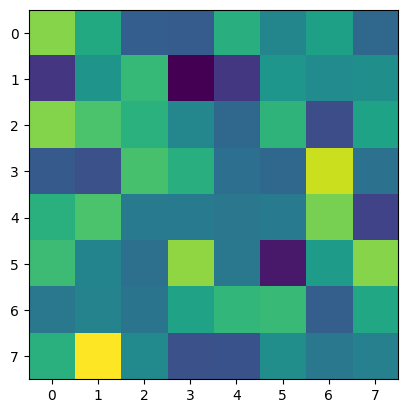

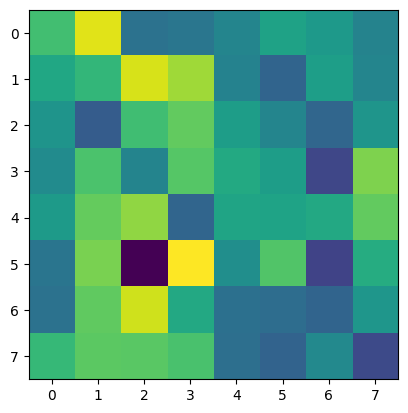

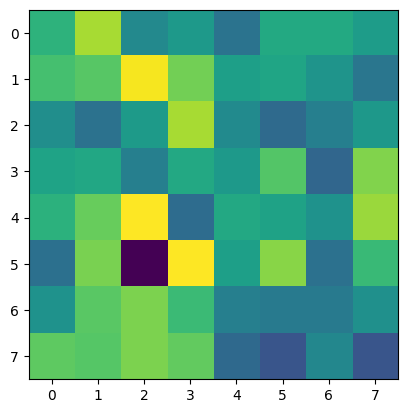

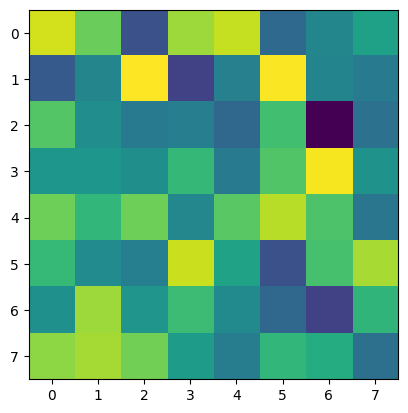

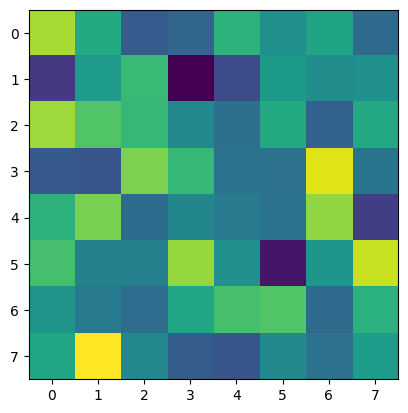

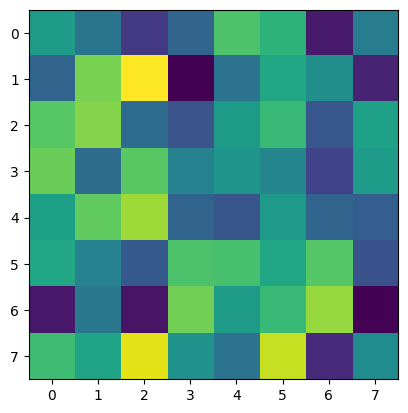

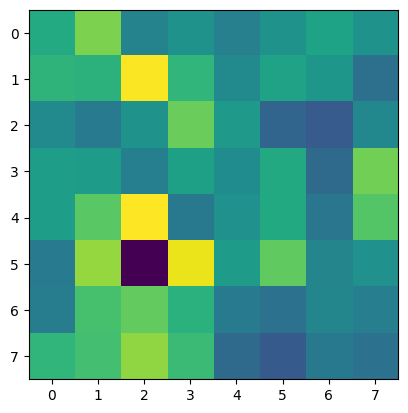

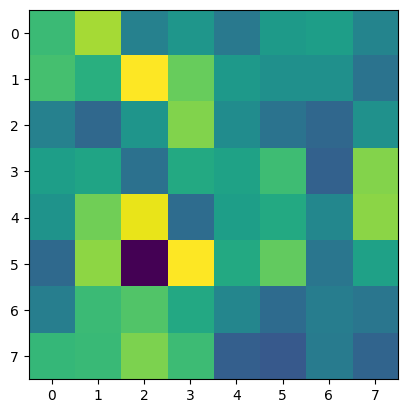

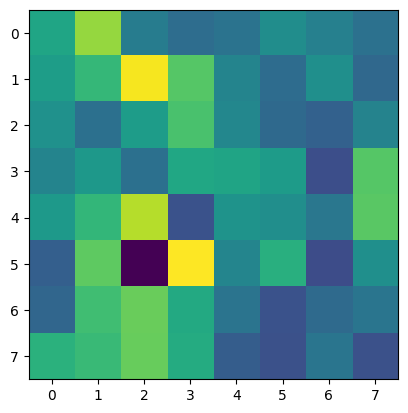

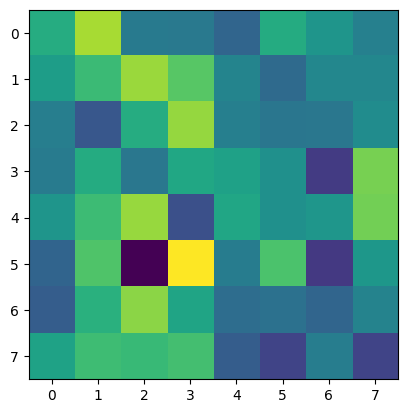

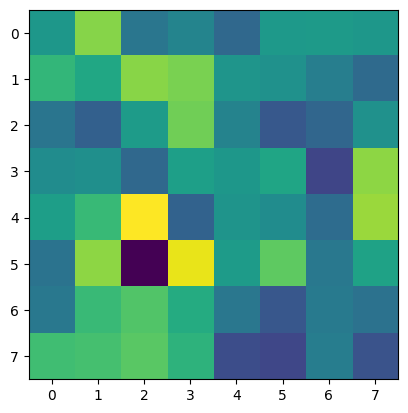

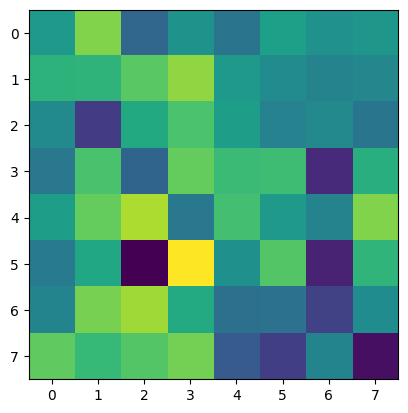

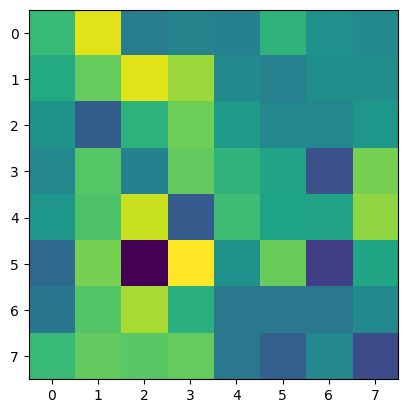

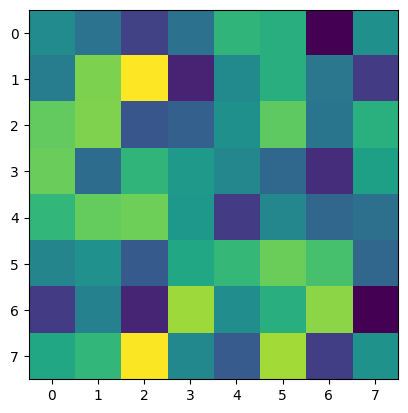

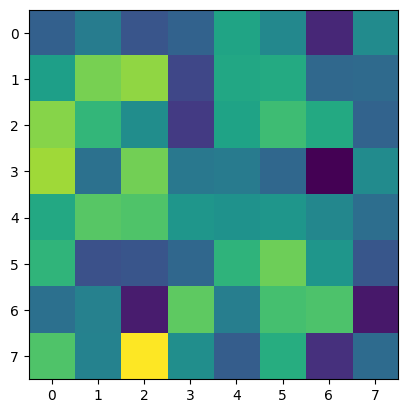

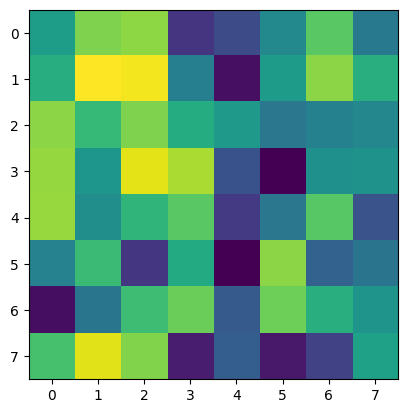

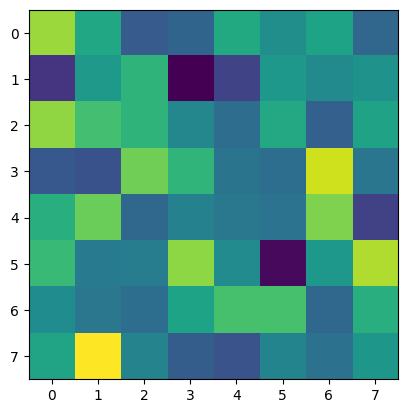

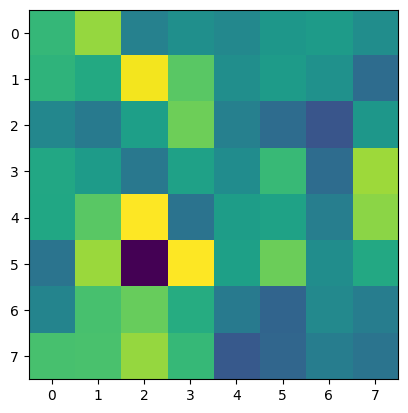

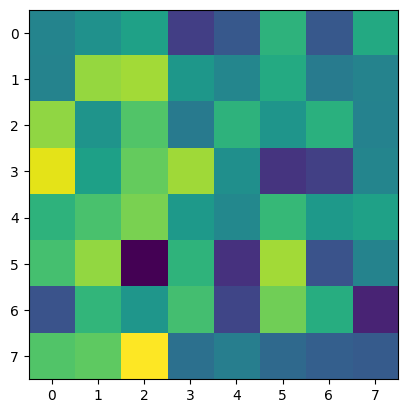

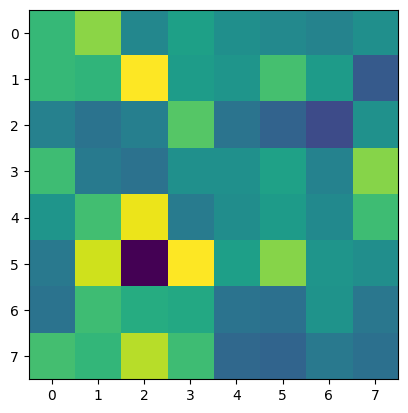

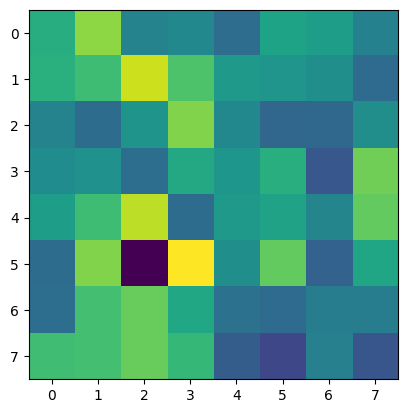

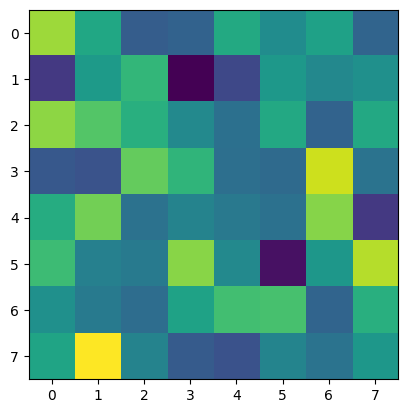

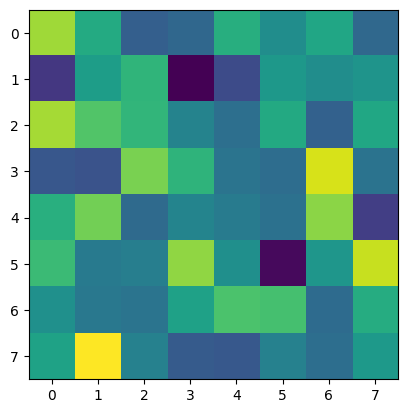

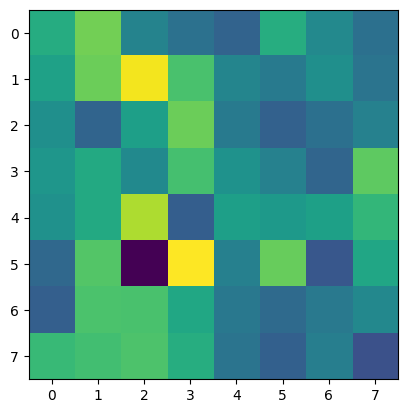

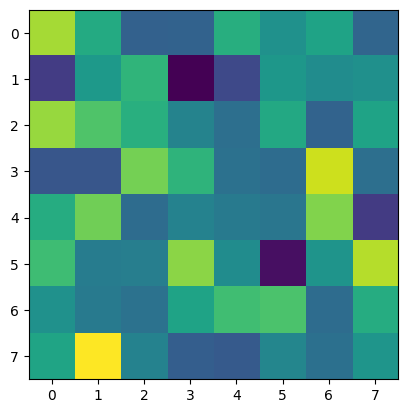

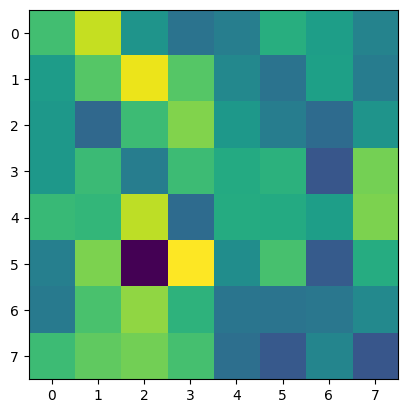

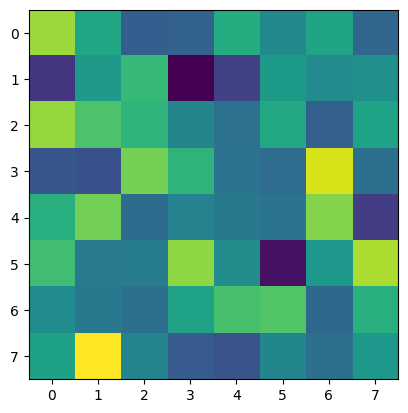

Game Loop Exited


In [11]:

# Run game loop
game_loop(diffusion_model, timesteps, input_dim)
